In [1]:
import matplotlib.pyplot as plt
import torch
import argparse
import os
import cv2
import sys
import numpy as np
from object_detection import ObjectDetector
from segmentation import SemanticSegmentation
from helpers import warped2scan, warp_driveable, get_driveable_mask,get_driveable_mask2
import math
from collections import deque



%matplotlib inline

# Test Segmentation

In [2]:
torch.backends.cudnn.benchmark = True

## Additional helper functions

In [3]:
def plot_segmendet_image(img, img_decoded):
    image=img.astype(np.float32)/255.0
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original = image.copy()
    original = cv2.resize(original,(img_decoded.shape[1], img_decoded.shape[0]))
    plt.imshow(np.concatenate((original, img_decoded), axis=0))
    plt.show()


In [4]:
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        #print(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
            
    return images, filenames

def seg2scan(driveable_area):
    h,w,_ = driveable_area.shape
    warped = cv2.warpPerspective(driveable_area, M, (480, 480), flags=cv2.INTER_LINEAR)
    original_center = np.array([[[w/2,h]]],dtype=np.float32)
    warped_center = cv2.perspectiveTransform(original_center, M)[0][0]
    scan_distances, angle_increment, warped_contours = warped2scan(warped, warped_center)
    return warped, warped_contours, scan_distances, angle_increment

def get_driveable(driveable_area):
    h,w,_ = driveable_area.shape
    # Warp driveable area
    warped = cv2.warpPerspective(driveable_area, M, (480, 480), flags=cv2.INTER_LINEAR)
    # Warp decoded image from semantic segmentation
#     warped_decoded = cv2.warpPerspective(img_decoded, M, (480, 480), flags=cv2.INTER_LINEAR)
    # Calculate robot center
    original_center = np.array([[[w/2,h]]],dtype=np.float32)
    warped_center = cv2.perspectiveTransform(original_center, M)[0][0]    
    
    driveable_contour_mask = get_driveable_mask2(warped, warped_center)

    return driveable_contour_mask

## Load models

In [5]:
segmentation_model_path = os.path.join('/usr/src/app/dev_ws/src/vision/vision', 'pretrained', 'hardnet70_cityscapes_model.pkl')
seg_model = SemanticSegmentation(segmentation_model_path)
object_detector = ObjectDetector()
# Load perspective transforms
mtxs = np.load('/usr/src/app/dev_ws/src/vision/vision/PerspectiveTransform.npz')
M = mtxs['M']
M_inv = mtxs['M_inv']

Semantic Segmentation using FCHardNet
Loading Object Detection


## Read image

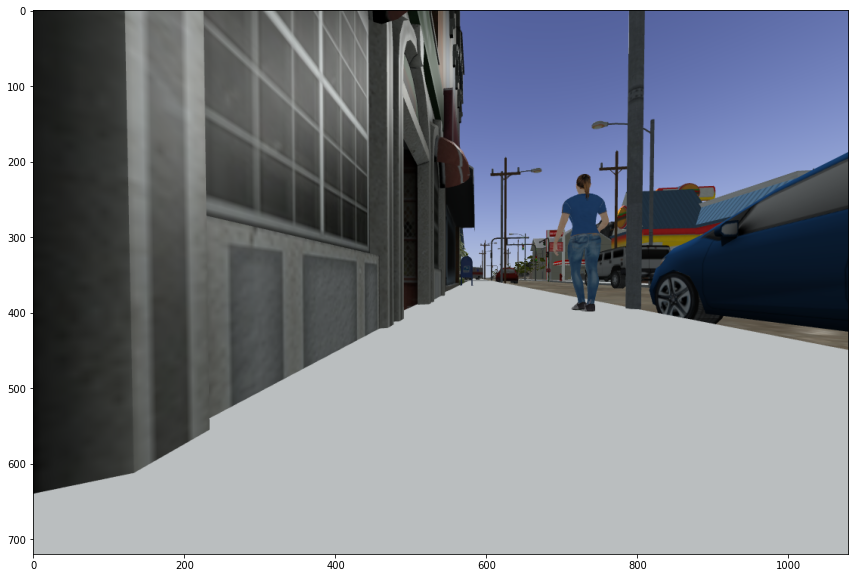

In [6]:
img = cv2.imread("./data/73.png")
# img = cv2.imread("./data/195.png")
h_orig,w_orig,_ = img.shape


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(img)
plt.show()


In [7]:
print(w_orig)

1080


# Process image

In [8]:
FORWARD_WEIGHT = 3.0
CENTER_WEIGHT = 0.5

HEIGHT=480
WIDTH=480
OSCILLATIONS_DETECTION_LENGTH = 3
PIXEL_PER_METER_X = (WIDTH - 2*150)/3.0 #Horizontal distance between src points in the real world ( I assumed 3.0 meters)
PIXEL_PER_METER_Y = (HEIGHT - 20-55)/6.0 #Vertical distance between src points in the real world ( I assumed 6.0 meters)
HORIZ_ANGLE_THRESHOLD = 15*math.pi/180.0
AVG_SIDEWALK_WIDTH = round(3.9*PIXEL_PER_METER_X)


def add_detections_birdview(preds, driveable_mask):
    h,w,_ = object_detector.im_hw 
    h_rate = h_orig/h
    w_rate = w_orig/w

    for pred in preds:
        if(pred[4] > object_detector.conf_thres):
            x = w_rate*(pred[0]+pred[2])/2.0
            y = h_rate*pred[3]
            if(pred[5]==0): #person
                wr = 20
                hr = 20
                color = 150
            else:
                wr = 20
                hr = 40
                color = 150
            pos_orig = np.array([[[x,y]]],dtype=np.float32)

            warped_birdview = cv2.perspectiveTransform(pos_orig, M)[0][0] 
            warped_birdview = np.uint16(warped_birdview)
            cv2.rectangle(driveable_mask, (warped_birdview[0] -int(wr/2), warped_birdview[1]-int(hr/2)), (warped_birdview[0] +int(wr/2), warped_birdview[1]+int(hr/2)), color, -1) 

def sidewalk_lines(mask, mask_out):
    mask = np.uint8(mask)
#     lines = cv2.HoughLinesP(mask, 2, 1*np.pi / 180, 100, None, 210, 50)
    lines = cv2.HoughLinesP(mask, 1, 1*np.pi / 180, 100, None, 150, 50)
    
    line_angles = []
    lines_left = []
    lines_right = []
    lines_found = True
    if(lines is not None):
        for line in lines:
            print(line)
            x2,y2,x1,y1 = line[0]
                # y = mx + b
#                 print(line)
            if(y2<y1):
                angle = -math.atan2(y2-y1,x2-x1)-math.pi/2
            else:
                angle = -math.atan2(y1-y2,x1-x2)-math.pi/2
            line_angles.append(angle)
            if(abs(angle-math.pi/2) < HORIZ_ANGLE_THRESHOLD):
                cv2.line(mask_out,(round(x1),round(y1)),(round(x2),round(y2)),100,1)
            if(x2 == x1):
                x2 += 1
#                     print(line)
            m = (y2-y1)/(x2-x1)
            b = y1-m*x1
            x3 = ((HEIGHT-b)/m)
            x3 = round(x3)
            x1 = x3
            y1 = HEIGHT
                    
            if(x3<WIDTH/2):
                lines_left.append([m,b,x2,y2,x1,y1])
            else:
                lines_right.append([m,b,x2,y2,x1,y1])
                        
                
#         print('lines_left: {}'.format(np.array(lines_left)))
#         print('lines_right: {}'.format(np.array(lines_right)))
        
                    
        #find average line left and right
        if(len(lines_left)>0 and len(lines_right) > 0): # Both lines are found
            lines_left = np.array(lines_left)
            m_avg_left = np.average(lines_left[:,0])
            b_avg_left = np.average(lines_left[:,1])
            if(m_avg_left == 0 ):
                m_avg_left = lines_left[0,0]
                b_avg_left = lines_left[0,1]
                
            y1_left = np.amin(lines_left[:,3])
#             print(m_avg_left)
            x1_left = (y1_left - b_avg_left) / m_avg_left
            x2_left = (HEIGHT-b_avg_left) / m_avg_left
            if x2_left > 0 and x2_left < WIDTH:
                y2_left = HEIGHT
            else:
                x2_left = 0
                y2_left = b_avg_left
            lines_right = np.array(lines_right)
            m_avg_right = np.average(lines_right[:,0])
            b_avg_right = np.average(lines_right[:,1])
            if(m_avg_right == 0 ):
                m_avg_right = lines_right[0,0]
                b_avg_right = lines_right[0,1]
    #             y1_right = min(100,np.amin(lines_right[:,3]))
            y1_right = np.amin(lines_right[:,3])

            x1_right = (y1_right - b_avg_right) / m_avg_right
            x2_right = (HEIGHT-b_avg_right) / m_avg_right
            if x2_right > 0 and x2_left < WIDTH:
                y2_right = HEIGHT
            else:
                x2_right = 0
                y2_right = b_avg_right
        elif(len(lines_left)>0): # Only left line was found
            print('right line not found, adding it')
            lines_left = np.array(lines_left)
            m_avg_left = np.average(lines_left[:,0])
            b_avg_left = np.average(lines_left[:,1])
            y1_left = np.amin(lines_left[:,3])
            x1_left = (y1_left - b_avg_left) / m_avg_left
            x2_left = (HEIGHT-b_avg_left) / m_avg_left
            if x2_left > 0 and x2_left < WIDTH:
                y2_left = HEIGHT
            else:
                x2_left = 0
                y2_left = b_avg_left
                
            m_avg_right = m_avg_left  
            b_avg_right = AVG_SIDEWALK_WIDTH*math.sqrt(m_avg_right**2+1)+b_avg_left
            if((b_avg_right - b_avg_left) < 0):
#                 print("si")
                b_avg_right = -AVG_SIDEWALK_WIDTH*math.sqrt(m_avg_right**2+1)+b_avg_left
            y1_right = y1_left
            x1_right = (y1_right - b_avg_right) / m_avg_right
            y2_right = y2_left
            x2_right = (y2_right - b_avg_right) / m_avg_right
            
        elif(len(lines_right)>0): # Only right line was found
            print('left line not found, adding it')
            lines_right = np.array(lines_right)
            m_avg_right = np.average(lines_right[:,0])
            b_avg_right = np.average(lines_right[:,1])
            y1_right = np.amin(lines_right[:,3])
            x1_right = (y1_right - b_avg_right) / m_avg_right
            x2_right = (HEIGHT-b_avg_right) / m_avg_right
            if x2_right > 0 and x2_right < WIDTH:
                y2_right = HEIGHT
            else:
                x2_right = 0
                y2_right = b_avg_right
                
            m_avg_left = m_avg_right  
            b_avg_left = -AVG_SIDEWALK_WIDTH*math.sqrt(m_avg_left**2+1)+b_avg_right
            if((b_avg_left - b_avg_right) < 0):
#                 print("si")
                b_avg_left = AVG_SIDEWALK_WIDTH*math.sqrt(m_avg_right**2+1)+b_avg_right
            y1_left = y1_right
            x1_left = (y1_left - b_avg_left) / m_avg_left
            y2_left = y2_right
            x2_left = (y2_left - b_avg_left) / m_avg_left
        else:
            angle_avg = 0
            lines_found = False
    else:
        lines_found = False
    angle_avg = np.average(line_angles)
    
    if(lines_found):
#         print([x1_right, y1_right, x2_right, y2_right])
#         print([x1_left, y1_left, x2_left, y2_left])
        angle_left = -math.atan2(y2_left-y1_left,x2_left-x1_left)-math.pi/2
        angle_right = -math.atan2(y2_right-y1_right,x2_right-x1_right)-math.pi/2
    
        cv2.line(mask_out,(round(x1_left),round(y1_left)),(round(x2_left),round(y2_left)),200,3)
        cv2.line(mask_out,(round(x1_right),round(y1_right)),(round(x2_right),round(y2_right)),200,3)
            # Calculate middle line
        
        angle_avg = (angle_left + angle_right) / 2.0
        m_avg = math.tan(-angle_avg+math.pi/2.0)
        
#         print(m_avg)
        
        x_center = ( x2_left + x2_right ) / 2.0
        b_avg = HEIGHT - m_avg*x_center
    else:
        m_avg = None
        b_avg = None
    
    return angle_avg, m_avg, b_avg
       
# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))
    
def obstacle_cost(mask_with_objects, gaussian_shape = 200):
    x = np.linspace(-2, 2,150)
    y = np.linspace(-2, 2,300)
    x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
    z = gaus2d(x, y)
    z = np.float32(z)
    cost_obst = cv2.filter2D(mask_with_objects,-1,z)
    cost_obst/=np.amax(cost_obst)
    return cost_obst
    
def forward_cost(angle):
    normal = np.array([math.tan(-angle),-1,HEIGHT])
    point = np.array([WIDTH/2, HEIGHT, 0])
    d = -np.sum(point*normal)# dot product
    xx, yy = np.meshgrid(range(WIDTH), range(HEIGHT))
    cost_forward = (-normal[0]*xx - normal[1]*yy - d)*1./normal[2]
    return cost_forward

def center_cost(m,b):
    if m is not None:
        xx, yy = np.meshgrid(range(WIDTH), range(HEIGHT))
        cost_center = abs(-m*xx+yy-b)/math.sqrt(m**2+1)
    else:
        cost_center = np.zeros((WIDTH,HEIGHT))
    return cost_center/np.amax(cost_center)


# Path Planning
def get_motion_model():
    # dx, dy
    motion = [
#               [1, 0], #right
#               [0, 2], #back
#               [-1, 0], #left
              [0, -4], # front
              [-1, -4],#front-left
              [-2, -4],#front-left
              [-3, -4],#front-left
              [-4, -4],#front-left
#               [-1, 2], # back-left
              [1, -4], #front-right
              [2, -4], #front-right
              [3, -4], #front-right
              [4, -4], #front-right
#               [1, 1]  #back-right
              ]
    return motion

def oscillations_detection(previous_ids, ix, iy):
    previous_ids.append((ix, iy))

    if (len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH):
        previous_ids.popleft()

    # check if contains any duplicates by copying into a set
    previous_ids_set = set()
    for index in previous_ids:
        if index in previous_ids_set:
            return True
        else:
            previous_ids_set.add(index)
    return False

def calculate_path(pmap):
    output = pmap.copy()*0
    motion = get_motion_model()
    previous_ids = deque()
    ix = round(WIDTH/2)
    iy = round(HEIGHT) 
    path = []
    while(ix > 5 and iy > 50 and ix< WIDTH-5):
        minp = float("inf")
        minix, miniy = 0, -1
        for i, _ in enumerate(motion):
            inx = int(ix + 1*motion[i][0])
            iny = int(iy + 1*motion[i][1])
            if inx >= WIDTH or iny >= HEIGHT or inx < 0 or iny < 0:
                p = float("inf")  # outside area
#                 print("outside potential!")
            else:
                p = pmap[iny][inx]
#                 print(p)
                    
            if minp >= p:
                min_motion = motion[i]
                minp = p
                minix = inx
                miniy = iny
        ix = minix
        iy = miniy
        # Calculate points
        px = (ix-WIDTH/2)/PIXEL_PER_METER_X
        py = (HEIGHT-iy)/PIXEL_PER_METER_Y
        path.append([px,py])
        if (oscillations_detection(previous_ids, ix, iy)):
            print("Oscillation detected at ({},{})!".format(ix, iy))
            break
        cv2.circle(output, (ix, iy),int(3.0),1, -1)
    
    return np.array(path),output

def draw_result(img, cost_obst, path_img):
    h_orig,w_orig,_ = img.shape
    
    result_birdview = cv2.merge([cost_obst, path_img, cost_obst*0])
    result_birdview = np.uint8(result_birdview*255.0)
    unwarped_birdview = cv2.warpPerspective(result_birdview, M_inv, (w_orig,h_orig), flags=cv2.INTER_LINEAR)
#     unwarped_birdview = np.uint8(unwarped_birdview*255.0)
    output = cv2.addWeighted(img, 0.7, unwarped_birdview, 0.5, 0)    
    return output, result_birdview


def process_img(img):
    h_orig,w_orig,_ = img.shape
    
    # Semantic Segmentation
    img_test = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_decoded, driveable_decoded = seg_model.process_img_driveable(img_test,[h_orig,w_orig])

    # Get bird eye view with driveable area limits
    driveable_mask  = get_driveable(driveable_decoded)

    # Object Detection
    preds = object_detector.process_frame(img)

    # Add Detections to birdview image
    driveable_mask_with_objects = driveable_mask.copy()
    add_detections_birdview(preds, driveable_mask_with_objects)

    # Find sidewalk edge lines and angle
    # h,w = driveable_mask.shape
    angle_avg, m_avg, b_avg = sidewalk_lines(driveable_mask, driveable_mask_with_objects) #driveable_mask_with_objects contains all objects and lines

    
    ## Find distance to center cost
    cost_center = center_cost(m_avg,b_avg)
    
 
    
    # Create obstacle cost map
    cost_obst = obstacle_cost(driveable_mask_with_objects)

    # Create inclination plane (forward cost)
    cost_forward = forward_cost(angle_avg)

    # Total cost
    cost_fcn = cost_obst+cost_forward*FORWARD_WEIGHT+cost_center*CENTER_WEIGHT
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.imshow(driveable_mask_with_objects)
    plt.show()   
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.imshow(cost_center)
    plt.show()  
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.imshow(cost_fcn)
    plt.show()   

    # Path Planning
    path, path_img = calculate_path(cost_fcn)

    # Plot result
    output, result_birdview = draw_result(img, cost_obst, path_img)

    return output, result_birdview



[[199 447 211  98]]
[[198 443 210  98]]
[[200 450 212  97]]
[[201 453 214  98]]
[[196 437 208  99]]
[[196 391 201 235]]
[[197 393 202 232]]
[[201 444 212 113]]
[[197 442 209  98]]
right line not found, adding it


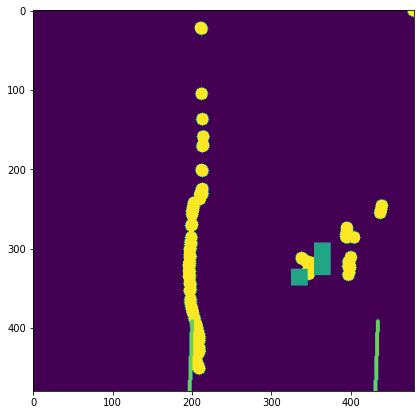

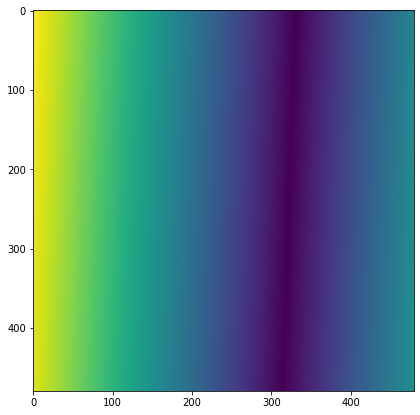

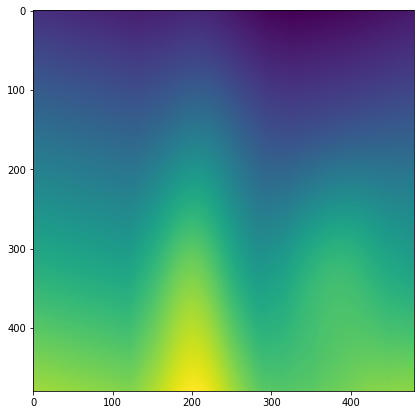

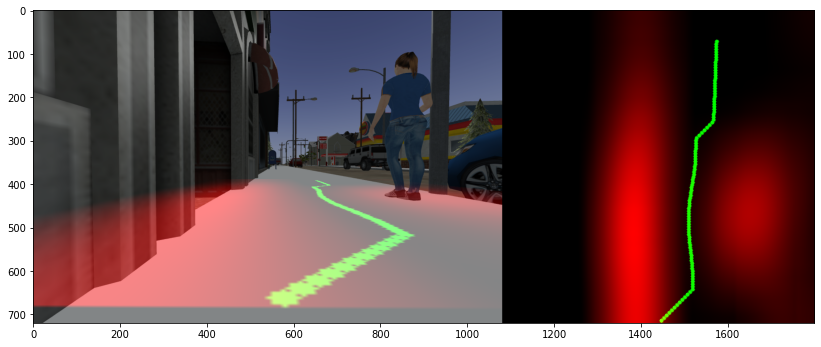

In [13]:
img = cv2.imread("./data/79.png") # 63 65 67 79 # 209
# img = cv2.imread("./data/195.png")
h_orig,w_orig,_ = img.shape
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)






output, result_birdview = process_img(img)

h,w,_ = output.shape
result_birdview = cv2.resize(result_birdview, (h,h), interpolation = cv2.INTER_AREA)
concat = cv2.hconcat([output, result_birdview])



fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(concat)
plt.show()   


In [15]:
import time

# FORWARD_WEIGHT = 3.0
# CENTER_WEIGHT = 0.5

# HEIGHT=480
# WIDTH=480
# OSCILLATIONS_DETECTION_LENGTH = 3
# PIXEL_PER_METER_X = (WIDTH - 2*150)/3.0 #Horizontal distance between src points in the real world ( I assumed 3.0 meters)
# PIXEL_PER_METER_Y = (HEIGHT - 20-55)/6.0 #Vertical distance between src points in the real world ( I assumed 6.0 meters)
# HORIZ_ANGLE_THRESHOLD = 15*math.pi/180.0
# AVG_SIDEWALK_WIDTH = round(4.0*PIXEL_PER_METER_X)


imgs, filenames = load_images_from_folder('./data')
print('processing {} images'.format(len(imgs)))
i=0
start = time.time()
for img, filename in zip(imgs, filenames):
    print('===============File: {} ============'.format(filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    output, result_birdview = process_img(img)
    h,w,_ = output.shape
    result_birdview = cv2.resize(result_birdview, (h,h), interpolation = cv2.INTER_AREA)
    concat = cv2.hconcat([output, result_birdview])
#     fig, ax = plt.subplots(figsize=(14, 7))
#     ax.imshow(concat)
#     plt.show()   
    concat = cv2.cvtColor(concat, cv2.COLOR_BGR2RGB)

    cv2.imwrite('./output/{}'.format(filename), concat)
    i = i+1
end = time.time()

processing 224 images
===============File: 112.png ============
===============File: 52.png ============
===============File: 105.png ============
===============File: 99.png ============
===============File: 111.png ============
===============File: 69.png ============
===============File: 72.png ============
===============File: 84.png ============
===============File: 138.png ============
===============File: 109.png ============
===============File: 121.png ============
===============File: 152.png ============
===============File: 132.png ============
===============File: 25.png ============
right line not found, adding it
===============File: 196.png ============
left line not found, adding it
===============File: 137.png ============
===============File: 56.png ============
===============File: 43.png ============
left line not found, adding it
===============File: 28.png ============
===============File: 195.png ============
left line not found, adding it
===============File: 2

In [16]:
print('avg time: {}'.format((end-start)/len(imgs)))

avg time: 0.26928739143269403
